## Configuration

Specify the path to your CSV file and whether it's a full or minimal export.

In [ ]:
# Configuration Parameters
import os

# Check if running in batch mode (environment variables set by orchestrator)
if 'MATCHUP_FOLDER' in os.environ:
    # Batch mode - use environment variables
    FOLDER_PATH = os.environ['MATCHUP_FOLDER']
    CSV_FILE_PATH = os.environ['CSV_FILE']
    CSV_INFO_FILE_PATH = os.environ['JSON_FILE']
    print(f"Batch mode: Analyzing {os.path.basename(FOLDER_PATH)}")
else:
    # Manual mode - use hardcoded paths
    FOLDER_PATH = r"results_20260105_100234"  # Update this path
    CSV_FILE_PATH = rf"{FOLDER_PATH}\all_games_minimal.csv"
    CSV_INFO_FILE_PATH = rf"{FOLDER_PATH}\simulation_summary.json"
    print(f"Manual mode: Analyzing {FOLDER_PATH}")

CSV_TYPE = "minimal"  # Options: "full" or "minimal"
INCLUDE_OT_GAMES = False  # Set to False to exclude overtime games

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import json

# Set visualization style
#sns.set_style("whitegrid")  # --- IGNORE ---
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully")

Libraries imported successfully


## Load and Prepare Data

In [3]:
# Load CSV data
df = pd.read_csv(CSV_FILE_PATH, sep=';')

print(f"Loaded {len(df)} rows from {CSV_FILE_PATH}")
print(f"\nNumber of unique games: {df['game_id'].nunique()}")

print(f"\nColumns in the dataset:")
for col in df.columns:
    print(f"- {col}")

# Load simulation summary information
with open(CSV_INFO_FILE_PATH, 'r') as f:
    sim_summary = json.load(f)

Loaded 2726806 rows from results_20260105_100234\all_games_minimal.csv

Number of unique games: 100000

Columns in the dataset:
- round_number
- is_t1_winner
- is_t1_ct
- is_ot
- outcome_reason_code
- outcome_bomb_planted
- t1_score_start
- t1_score_end
- t1_spent
- t1_earned
- t1_funds_start
- t1_rs_eq
- t1_fte_eq
- t1_re_eq
- t1_survivors
- t1_consecutive_losses
- t1_consecutive_losses_start
- t1_consecutive_wins
- t1_consecutive_wins_start
- t1_loss_bonus_level
- t2_score_start
- t2_score_end
- t2_spent
- t2_earned
- t2_funds_start
- t2_rs_eq
- t2_fte_eq
- t2_re_eq
- t2_survivors
- t2_consecutive_losses
- t2_consecutive_losses_start
- t2_consecutive_wins
- t2_consecutive_wins_start
- t2_loss_bonus_level
- game_id


## Filter Data

In [4]:

# Apply OT filter
if not INCLUDE_OT_GAMES:
    df_filtered = df[df['is_ot'] == False].copy()
    print(f"Excluded OT games. Total rows: {len(df_filtered)} ({len(df_filtered)/len(df)*100:.1f}% of original)")
else:
    df_filtered = df.copy()
    print(f"Including all games (with OT). Total rows: {len(df_filtered)}")

print(f"\nGames after filter: {df_filtered['game_id'].nunique()}")
print(f"Rounds with OT: {df_filtered['is_ot'].sum()}")
print(f"Rounds without OT: {(~df_filtered['is_ot']).sum()}")

Excluded OT games. Total rows: 2310227 (84.7% of original)

Games after filter: 88694
Rounds with OT: 0
Rounds without OT: 2310227


## Data Summary Statistics

In [5]:
# Summary statistics
print("=" * 60)
print("ECONOMIC METRICS SUMMARY")
print("=" * 60)



# Team 1 statistics
print(f"\nTeam 1: {sim_summary['simulation_config']['team1_strategy']}")
print(f"  Avg Starting Funds: ${df_filtered['t1_funds_start'].mean():.2f}")
print(f"  Avg FTE Equipment: ${df_filtered['t1_fte_eq'].mean():.2f}")
print(f"  Avg Spent per Round: ${df_filtered['t1_spent'].mean():.2f}")
print(f"  Avg Earned per Round: ${df_filtered['t1_earned'].mean():.2f}")

# Team 2 statistics
print(f"\nTeam 2: {sim_summary['simulation_config']['team2_strategy']}")
print(f"  Avg Starting Funds: ${df_filtered['t2_funds_start'].mean():.2f}")
print(f"  Avg FTE Equipment: ${df_filtered['t2_fte_eq'].mean():.2f}")
print(f"  Avg Spent per Round: ${df_filtered['t2_spent'].mean():.2f}")
print(f"  Avg Earned per Round: ${df_filtered['t2_earned'].mean():.2f}")


print("\n" + "=" * 60)

ECONOMIC METRICS SUMMARY

Team 1: all_in
  Avg Starting Funds: $14799.46
  Avg FTE Equipment: $23638.30
  Avg Spent per Round: $14799.46
  Avg Earned per Round: $15752.31

Team 2: anti_allin_v2
  Avg Starting Funds: $14799.22
  Avg FTE Equipment: $23646.48
  Avg Spent per Round: $14799.22
  Avg Earned per Round: $15752.05



### Length of game

In [6]:
# Score lengths and scoreline percentages (non-OT, using df_filtered/last_scores)

# Use existing per-game final scores if available, otherwise compute from df_filtered


scores = (
    df_filtered.sort_values(['game_id', 'round_number'])
    .groupby('game_id')
    .agg(t1_final=('t1_score_end', 'last'), t2_final=('t2_score_end', 'last'))
)

# Labels for teams
t1_label = sim_summary['simulation_config'].get('team1_strategy', 'Team 1')
t2_label = sim_summary['simulation_config'].get('team2_strategy', 'Team 2')

# Prepare helpers
scores['total_rounds'] = scores['t1_final'] + scores['t2_final']
scores['higher'] = scores[['t1_final', 't2_final']].max(axis=1)
scores['lower'] = scores[['t1_final', 't2_final']].min(axis=1)
scores['canon'] = scores['higher'].astype(int).astype(str) + ':' + scores['lower'].astype(int).astype(str)  # e.g., "16:14"
t1_won_mask = scores['t1_final'] > scores['t2_final']
t2_won_mask = ~t1_won_mask


# 2) Overall canonical scorelines (treat 16:14 = 14:16)
canon_overall = (
    scores.groupby(['higher', 'lower', 'canon'])
    .size()
    .reset_index(name='count')
)
canon_overall['total_rounds'] = canon_overall['higher'] + canon_overall['lower']
canon_overall['pct'] = (canon_overall['count'] / len(scores) * 100).round(2)
canon_overall = canon_overall.sort_values(['total_rounds', 'higher', 'lower']).set_index('canon')[['count', 'pct', 'total_rounds']]

# 3) Score lengths by team (winner-only), side by side
_length_t1 = scores.loc[t1_won_mask, 'total_rounds'].value_counts()
_length_t2 = scores.loc[t2_won_mask, 'total_rounds'].value_counts()
length_by_team = pd.DataFrame({
    f'{t1_label}_count': _length_t1,
    f'{t2_label}_count': _length_t2
}).fillna(0).astype(int).sort_index()
length_by_team[f'{t1_label}_pct'] = (length_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(2)
length_by_team[f'{t2_label}_pct'] = (length_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(2)

# 4) Canonical scorelines by team (winner-only), side by side
_canon_t1 = scores.loc[t1_won_mask, 'canon'].value_counts()
_canon_t2 = scores.loc[t2_won_mask, 'canon'].value_counts()
canon_by_team = pd.DataFrame({
    f'{t1_label}_count': _canon_t1,
    f'{t2_label}_count': _canon_t2
}).fillna(0).astype(int)

# Add percentages per team (normalize within each team's wins)
canon_by_team[f'{t1_label}_pct'] = (canon_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(2)
canon_by_team[f'{t2_label}_pct'] = (canon_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(2)



# Display

print("\nOverall canonical scorelines (winner:loser):")
print(canon_overall[['total_rounds','count', 'pct']].to_string())

print(f"\nScore lengths by team (winner-only): [{t1_label} vs {t2_label}]")
print(length_by_team.to_string())




Overall canonical scorelines (winner:loser):
       total_rounds  count    pct
canon                            
16:0             16    171   0.19
16:1             17    401   0.45
16:2             18    842   0.95
16:3             19   1437   1.62
16:4             20   2357   2.66
16:5             21   3329   3.75
16:6             22   4466   5.04
16:7             23   5807   6.55
16:8             24   7218   8.14
16:9             25   8086   9.12
16:10            26   9478  10.69
16:11            27  10342  11.66
16:12            28  11347  12.79
16:13            29  11797  13.30
16:14            30  11616  13.10

Score lengths by team (winner-only): [all_in vs anti_allin_v2]
              all_in_count  anti_allin_v2_count  all_in_pct  anti_allin_v2_pct
total_rounds                                                                  
16                      84                   87        0.19               0.20
17                     196                  205        0.44               0

## Way to win - Calculation & Visualization

Refactored calculation with helper functions for better readability, plus Sankey and Graphviz visualizations.

In [7]:
# ============================================================================
# IMPROVED CALCULATION - Cleaner, more modular code
# ============================================================================

def extract_game_ids(df, team_col, round_num, condition=None):
    """Extract game IDs for specific round outcomes"""
    if condition is None:
        mask = (df[team_col] == True) & (df['round_number'] == round_num)
    else:
        mask = condition & (df['round_number'] == round_num)
    return set(df[mask]['game_id'])

def calculate_branch_counts(parent_games, *filters):
    """Calculate counts for multiple branches from a parent set"""
    results = []
    for filter_games in filters:
        count = len(parent_games & filter_games)
        results.append(count)
    return results

# Extract base round outcomes
print("Extracting game outcomes...")
total_games = df_filtered['game_id'].nunique()

# R1 outcomes
t1_r1_win = extract_game_ids(df_filtered, 'is_t1_winner', 1)
t2_r1_win = set(df_filtered[df_filtered['round_number'] == 1]['game_id']) - t1_r1_win

# R2 outcomes
t1_r2_win = extract_game_ids(df_filtered, 'is_t1_winner', 2)
t2_r2_win = set(df_filtered[df_filtered['round_number'] == 2]['game_id']) - t1_r2_win

# R15 lead/behind (at end of first half)
t1_r15_lead = extract_game_ids(df_filtered, None, 15, 
                               df_filtered['t1_score_end'] > df_filtered['t2_score_end'])
t2_r15_lead = extract_game_ids(df_filtered, None, 15,
                               df_filtered['t2_score_end'] > df_filtered['t1_score_end'])

# R16 outcomes
t1_r16_win = extract_game_ids(df_filtered, 'is_t1_winner', 16)
t2_r16_win = set(df_filtered[df_filtered['round_number'] == 16]['game_id']) - t1_r16_win

# R17 outcomes
t1_r17_win = extract_game_ids(df_filtered, 'is_t1_winner', 17)
t2_r17_win = set(df_filtered[df_filtered['round_number'] == 17]['game_id']) - t1_r17_win

# Final game outcomes
game_scores = df_filtered.groupby('game_id')[['t1_score_end','t2_score_end', 'is_t1_winner', 'round_number']].max()
t1_overall_win = set(game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index)
t2_overall_win = set(game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index)

# ============================================================================
# Calculate all branch counts using helper functions
# ============================================================================

print("Calculating branch counts...")

# Level 1: R1 split
r1_counts = {
    't1_wins': len(t1_r1_win),
    't2_wins': len(t2_r1_win)
}

# Level 2: R2 outcomes for each R1 branch
t1_r2_branches = calculate_branch_counts(t1_r1_win, t1_r2_win, t2_r2_win)
t2_r2_branches = calculate_branch_counts(t2_r1_win, t2_r2_win, t1_r2_win)

# Level 3: R15 outcomes for each R2 branch
# T1 R1 win -> T1 R2 win
t1r1w_t1r2w = t1_r1_win & t1_r2_win
t1r1w_t1r2w_r15 = calculate_branch_counts(t1r1w_t1r2w, t1_r15_lead, t2_r15_lead)

# T1 R1 win -> T1 R2 loss
t1r1w_t1r2l = t1_r1_win & t2_r2_win
t1r1w_t1r2l_r15 = calculate_branch_counts(t1r1w_t1r2l, t1_r15_lead, t2_r15_lead)

# T2 R1 win -> T2 R2 win
t2r1w_t2r2w = t2_r1_win & t2_r2_win
t2r1w_t2r2w_r15 = calculate_branch_counts(t2r1w_t2r2w, t2_r15_lead, t1_r15_lead)

# T2 R1 win -> T2 R2 loss
t2r1w_t2r2l = t2_r1_win & t1_r2_win
t2r1w_t2r2l_r15 = calculate_branch_counts(t2r1w_t2r2l, t2_r15_lead, t1_r15_lead)

# Level 4: R16 outcomes for each R15 branch
# T1 paths
t1_r16_branches = calculate_branch_counts(t1_r15_lead, t1_r16_win, t2_r16_win)
# T2 paths
t2_r16_branches = calculate_branch_counts(t2_r15_lead, t2_r16_win, t1_r16_win)

#Level 5: R17 outcomes for each R16 Branch
#T1 Path
t1h1l_r16w = t1_r15_lead & t1_r16_win
t1h1l_t1r16w_r17 = calculate_branch_counts(t1h1l_r16w, t1_r17_win, t2_r17_win)

t1h1l_r16l = t1_r15_lead & t2_r16_win
t1h1l_t1r16l_r17 = calculate_branch_counts(t1h1l_r16l, t1_r17_win, t2_r17_win)

#T2 Path
t2h1l_r16w = t2_r15_lead & t2_r16_win
t2h1l_t2r16w_r17 = calculate_branch_counts(t2h1l_r16w, t2_r17_win, t1_r17_win)

t2h1l_r16l = t2_r15_lead & t1_r16_win
t2h1l_t2r16l_r17 = calculate_branch_counts(t2h1l_r16l, t2_r17_win, t1_r17_win)

# Level 5: Final outcomes for each R17 branch
# T1 R2 win paths
t1_final_counts = {
    'r15lead_r16w_r17w': calculate_branch_counts(t1h1l_r16w & t1_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16w_r17l': calculate_branch_counts(t1h1l_r16w & t2_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16l_r17w': calculate_branch_counts(t1h1l_r16l & t1_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16l_r17l': calculate_branch_counts(t1h1l_r16l & t2_r17_win, t1_overall_win, t2_overall_win),
}

# T2 final paths
t2_final_counts = {
    'r15lead_r16w_r17w': calculate_branch_counts(t2h1l_r16w & t2_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16w_r17l': calculate_branch_counts(t2h1l_r16w & t1_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16l_r17w': calculate_branch_counts(t2h1l_r16l & t2_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16l_r17l': calculate_branch_counts(t2h1l_r16l & t1_r17_win, t2_overall_win, t1_overall_win),
}

print(f"✓ Calculation complete! Total games: {total_games}")
print(f"  T1 R1 wins: {r1_counts['t1_wins']} ({r1_counts['t1_wins']/total_games*100:.1f}%)")
print(f"  T2 R1 wins: {r1_counts['t2_wins']} ({r1_counts['t2_wins']/total_games*100:.1f}%)")

Extracting game outcomes...
Calculating branch counts...
✓ Calculation complete! Total games: 88694
  T1 R1 wins: 44297 (49.9%)
  T2 R1 wins: 44397 (50.1%)


In [8]:
# ============================================================================
# SANKEY DIAGRAM - Interactive flow visualization
# ============================================================================

import plotly.graph_objects as go

def create_sankey_data():
    """Build Sankey diagram source/target/value arrays"""
    
    # Node labels (indexed)
    labels = [
        "All Games",  # 0
        
        # R1 level
        "T1 WIN R1", "T2 WIN R1",  # 1, 2
        
        # R2 level - T1 path
        "T1 WIN R2", "T1 LOSE R2",  # 3, 4
        # R2 level - T2 path
        "T2 WIN R2", "T2 LOSE R2",  # 5, 6
        
        # R15 level - T1 win
        "T1 AHEAD First Half",   # 7, 
        # R15 level - T2 loss
        "T2 AHEAD First Half",   # 8, 
        
        # R16 level - T1 paths (2 nodes)
        "T1 WIN R16", "T1 LOSE R16",  # 9, 10
        
        # R16 level - T2 paths (2 nodes)
        "T2 WIN R16", "T2 LOSE R16",  # 11, 12

        
        # R17 level - T1 paths (4 nodes)
        "T1 WIN R17 (Lead,R16W)", "T1 LOSE R17 (Lead,R16W)",  # 13, 14
        "T1 WIN R17 (Lead,R16L)", "T1 LOSE R17 (Lead,R16L)",  # 15, 16
        
        # R17 level - T2 paths (4 nodes)
        "T2 WIN R17 (Lead,R16W)", "T2 LOSE R17 (Lead,R16W)",  # 17, 18
        "T2 WIN R17 (Lead,R16L)", "T2 LOSE R17 (Lead,R16L)",  # 19, 20

        # Final outcomes - T1 (4 nodes)
        "T1 WIN (R15Lead,R16W,R17W)", #21
        "T1 WIN (R15Lead,R16W,R17L)", #22
        "T1 WIN (R15Lead,R16L,R17W)", #23
        "T1 WIN (R15Lead,R16L,R17L)", #24

        # Final outcomes - T2 (8 nodes)
        "T2 WIN (R15Lead,R16W,R17W)", #25
        "T2 WIN (R15Lead,R16W,R17L)", #26
        "T2 WIN (R15Lead,R16L,R17W)", #27
        "T2 WIN (R15Lead,R16L,R17L)", #28
    ]
    
    sources = []
    targets = []
    values = []
    
    # Root to R1
    sources.extend([0, 0])
    targets.extend([1, 2])
    values.extend([r1_counts['t1_wins'], r1_counts['t2_wins']])
    
    # R1 to R2
    sources.extend([1, 1, 2, 2])
    targets.extend([3, 4, 5, 6])
    values.extend(t1_r2_branches + t2_r2_branches)
    
    # R2 to R15 - Merge paths - Lead
    sources.extend([3, 3, 4, 4, 5, 5, 6, 6])
    targets.extend([7, 8, 7, 8, 8, 7, 8, 7])
    values.extend(t1r1w_t1r2w_r15 + t1r1w_t1r2l_r15 + t2r1w_t2r2w_r15 + t2r1w_t2r2l_r15)
    
    # R15 to R16 
    sources.extend([7, 7, 8, 8])
    targets.extend([9, 10, 11, 12])
    values.extend(t1_r16_branches + t2_r16_branches)
    
    # R16 to R17 - T1 paths
    sources.extend([9, 9, 10, 10])
    targets.extend([13, 14, 15, 16])
    values.extend(t1h1l_t1r16w_r17 + t1h1l_t1r16l_r17)

    # R16 to R17 - T2 paths
    sources.extend([11, 11, 12, 12])
    targets.extend([17, 18, 19, 20])
    values.extend(t2h1l_t2r16w_r17 + t2h1l_t2r16l_r17)
    
    # R17 to Final - T1 paths
    t1_r17_indices = [13, 13, 14, 14, 15, 15, 16, 16]
    t1_final_indices = [21, 25, 22, 26, 23, 27, 24, 28]
    sources.extend(t1_r17_indices)
    targets.extend(t1_final_indices)
    t1_final_values = [v for path_counts in t1_final_counts.values() for v in path_counts]
    values.extend(t1_final_values)
    
    # R16 to Final - T2 paths
    t2_r17_indices = [17, 17, 18, 18, 19, 19, 20, 20]
    t2_final_indices = [25, 21, 26, 22, 27, 23, 28, 24]
    sources.extend(t2_r17_indices)
    targets.extend(t2_final_indices)
    t2_final_values = [v for path_counts in t2_final_counts.values() for v in path_counts]
    values.extend(t2_final_values)
    
    return labels, sources, targets, values

# Create Sankey diagram
print("Building Sankey diagram...")
labels, sources, targets, values = create_sankey_data()

# Color scheme
node_colors = []
for label in labels:
    if "T1 WIN" in label or "T1 AHEAD" in label:
        node_colors.append("rgba(73, 245, 39, 0.8)")  # Green
    elif "T1 LOSE" in label or "T1 BEHIND" in label:
        node_colors.append("rgba(245, 155, 39, 0.8)")  # Orange
    elif "T2 WIN" in label or "T2 AHEAD" in label:
        node_colors.append("rgba(39, 52, 245, 0.8)")  # Blue
    elif "T2 LOSE" in label or "T2 BEHIND" in label:
        node_colors.append("rgba(245, 39, 228, 0.8)")  # Purple
    elif "All Games" in label or "T1" in label or "T2" in label:
        node_colors.append("rgba(39, 245, 232, 0.8)")  # Turquoise
    else:
        node_colors.append("rgba(223, 230, 233, 0.8)")  # Gray

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(200, 200, 200, 0.4)"
    )
)])

fig.update_layout(
    title=dict(
        text="Game Progression Flow - Sankey Diagram<br><sub>Width represents number of games flowing through each path</sub>",
        font=dict(size=20, family="Arial Black")
    ),
    font=dict(size=10),
    height=1200,
    width=1600,
)

fig.show()

print(f"✓ Sankey diagram complete with {len(labels)} nodes and {len(values)} flows")

# TODO: This graph can be improved. noteably, the last part is very chaotic. 
# Also potentially do not include category lose, instead only use t1 win/t2 win 
# and improve ordering of the bars (t1 top, t2 bottom)

Building Sankey diagram...


✓ Sankey diagram complete with 29 nodes and 42 flows


### Heatmap of score progression

In [9]:
# Step 1: Create temporary dataframe - count occurrences per unique round number
round_counts_temp = df_filtered.groupby('round_number').size().reset_index(name='total_occurrences')

# Step 2: Create permanent dataframe - for each round number and scoreline, count occurrences
# Create scoreline column (e.g., "10-5" format)
df_filtered['scoreline'] = df_filtered['t1_score_end'].astype(str) + '-' + df_filtered['t2_score_end'].astype(str)

# Group by round_number and scoreline to get occurrence counts
scoreline_by_round_df = df_filtered.groupby(['round_number', 'scoreline', 't1_score_end', 't2_score_end']).size().reset_index(name='scoreline_occurrences')

# Step 3: Merge with round counts to calculate percentages
scoreline_by_round_df = scoreline_by_round_df.merge(
    round_counts_temp[['round_number', 'total_occurrences']], 
    on='round_number', 
    how='left'
)

# Calculate percentage
scoreline_by_round_df['percentage'] = (scoreline_by_round_df['scoreline_occurrences'] / 
                                        scoreline_by_round_df['total_occurrences'] * 100)

# Sort for better readability
scoreline_by_round_df = scoreline_by_round_df.sort_values(['round_number', 'scoreline_occurrences'], ascending=[True, False])

print(f"\nTotal unique round numbers: {scoreline_by_round_df['round_number'].nunique()}")
print(f"Total unique scorelines across all rounds: {scoreline_by_round_df['scoreline'].nunique()}")


Total unique round numbers: 30
Total unique scorelines across all rounds: 284


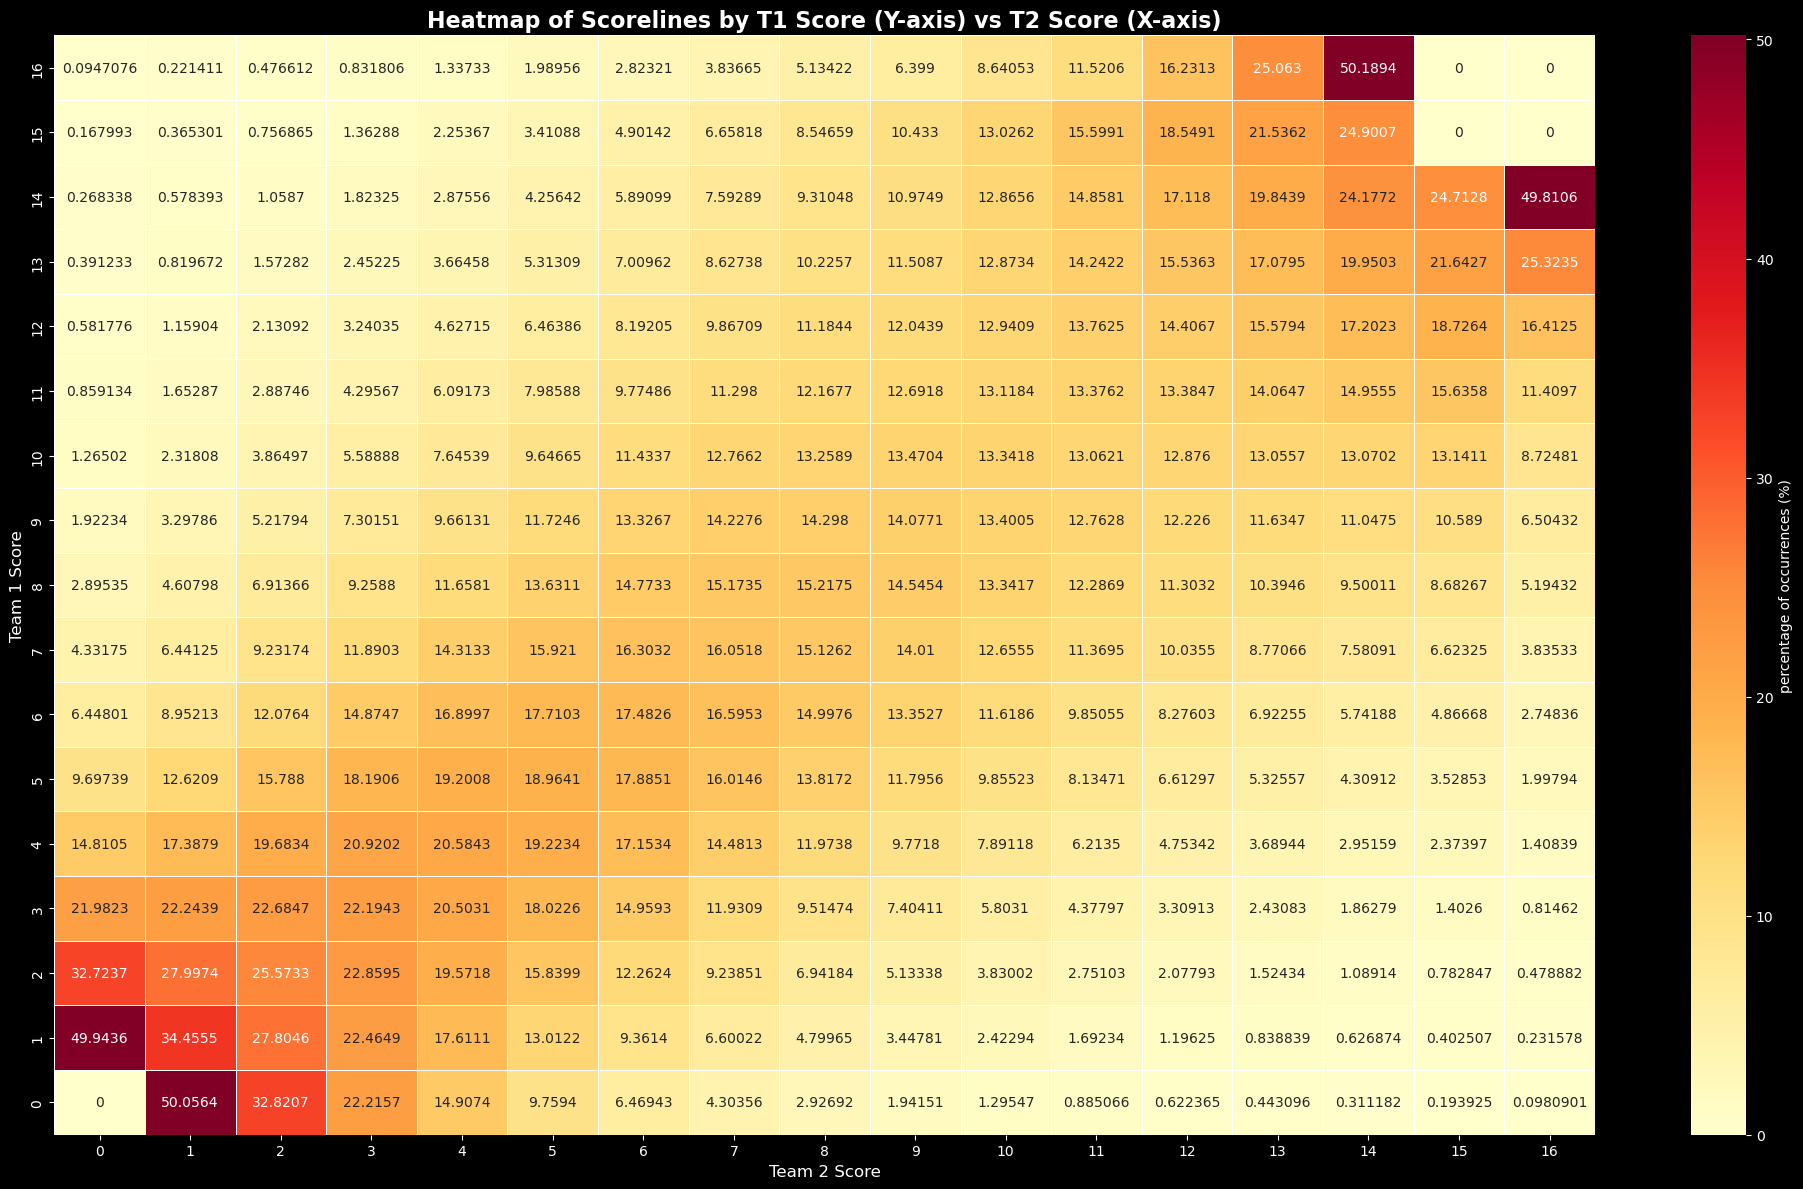

Heatmap created showing 17 T1 scores across 17 T2 scores


In [10]:
# Create a pivot table for the heatmap
# We'll use round_number as x-axis and scoreline as y-axis, with scoreline_occurrences as values
heatmap_data = scoreline_by_round_df[['t1_score_end', 't2_score_end', 'percentage']]

# Create pivot table using t1_score_end and t2_score_end
pivot_data = heatmap_data.pivot_table(
    index='t1_score_end',
    columns='t2_score_end',
    values='percentage',
    aggfunc='sum',
    fill_value=0
)

# Sort by index and columns
pivot_data = pivot_data.sort_index(ascending=False).sort_index(axis=1, ascending=True)

# Create the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(pivot_data, 
            cmap='YlOrRd', 
            annot=True, 
            fmt='g',
            cbar_kws={'label': 'percentage of occurrences (%)'},
            linewidths=0.5)

plt.title('Heatmap of Scorelines by T1 Score (Y-axis) vs T2 Score (X-axis)', fontsize=16, fontweight='bold')
plt.xlabel('Team 2 Score', fontsize=12)
plt.ylabel('Team 1 Score', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Heatmap created showing {len(pivot_data)} T1 scores across {len(pivot_data.columns)} T2 scores")

### progression of all scoreline in sankey
#### TODO: this needs to be fixed, terrible graph

In [11]:
import plotly.graph_objects as go
import re

#TODO: improve node positioning to reduce overlap and improve clarity

# Create scoreline progression data
# For each game, track the scoreline after each round
df_sorted = df_filtered.sort_values(['game_id', 'round_number'])

# Build transitions from one round to the next
transitions = []
for game_id, game_data in df_sorted.groupby('game_id'):
    game_data = game_data.sort_values('round_number')
    prev_scoreline = "Start 0-0"
    prev_round = 0
    
    for idx, row in game_data.iterrows():
        curr_scoreline = f"R{row['round_number']} {row['t1_score_end']}-{row['t2_score_end']}"
        transitions.append({
            'source': prev_scoreline,
            'target': curr_scoreline,
            'round_from': prev_round,
            'round_to': row['round_number']
        })
        prev_scoreline = curr_scoreline
        prev_round = row['round_number']

# Count transitions
transition_counts = pd.DataFrame(transitions).groupby(['source', 'target']).size().reset_index(name='count')

# Create node labels (unique scorelines)
all_nodes = list(set(transition_counts['source'].tolist() + transition_counts['target'].tolist()))

# Function to extract scores and calculate sort key
def get_sort_key(node_label):
    """Extract t1_score and t2_score from node label and return sort key"""
    if node_label == "Start 0-0":
        return (0, 0, 0)  # Start in middle
    
    # Extract round number and scores using regex
    match = re.match(r"R(\d+)\s+(\d+)-(\d+)", node_label)
    if match:
        round_num = int(match.group(1))
        t1_score = int(match.group(2))
        t2_score = int(match.group(3))
        score_diff = t1_score - t2_score  # Positive = T1 winning, Negative = T2 winning
        return (round_num, -score_diff, t1_score)  # Sort by round, then by score diff (negative for top-to-bottom), then by t1_score
    return (0, 0, 0)

# Sort nodes by score difference (higher T1 scores at top, higher T2 scores at bottom)
all_nodes_with_keys = [(node, get_sort_key(node)) for node in all_nodes]
all_nodes_with_keys.sort(key=lambda x: x[1])
all_nodes_sorted = [node for node, key in all_nodes_with_keys]

# Create node dict with sorted order
# node_dict = {node: idx for idx, node in enumerate(all_nodes_sorted)}

# Group nodes by round and assign evenly distributed y-coordinates within each round
# This prevents overlapping

# nodes_by_round = {}
# for node in all_nodes_sorted:
#     round_num, neg_score_diff, t1_score = get_sort_key(node)
#     if round_num not in nodes_by_round:
#         nodes_by_round[round_num] = []
#     nodes_by_round[round_num].append((node, -neg_score_diff))  # Store node with score_diff

# Assign y-coordinates - distribute nodes evenly within each round based on their score diff order
# node_y_coords = []
# node_x_coords = []
# for node in all_nodes_sorted:
#     round_num, neg_score_diff, t1_score = get_sort_key(node)
#     score_diff = -neg_score_diff
    
#     # Get nodes in this round sorted by score difference
#     round_nodes = sorted(nodes_by_round[round_num], key=lambda x: x[1], reverse=True)
#     num_nodes_in_round = len(round_nodes)
    
#     # Find index of current node in this round
#     node_index = next(i for i, (n, sd) in enumerate(round_nodes) if n == node)
    
#     # Distribute nodes evenly from 0 to 1 with padding
#     if num_nodes_in_round == 1:
#         y_coord = 0.5
#     else:
#         # Add padding margins (5% top and bottom)
#         y_coord = 0.05 + (node_index / (num_nodes_in_round - 1)) * 0.9
    
#     node_y_coords.append(y_coord)
    
#     # X-coordinate based on round number
#     if node == "Start 0-0":
#         x_coord = 0.0
#     else:
#         x_coord = round_num / 30  # Normalize to 0-1 range
#     node_x_coords.append(x_coord)

# # Create source, target, value lists for Sankey
# sources = [node_dict[src] for src in transition_counts['source']]
# targets = [node_dict[tgt] for tgt in transition_counts['target']]
# values = transition_counts['count'].tolist()

# Create Sankey diagram with positioned nodes

# fig = go.Figure(data=[go.Sankey(
#     node=dict(
#         pad=5,
#         thickness=10,
#         line=dict(color="black", width=0.5),
#         label=all_nodes_sorted,
#         color="lightblue",
#         x=node_x_coords,
#         y=node_y_coords
#     ),
#     link=dict(
#         source=sources,
#         target=targets,
#         value=values
#     )
# )])

# fig.update_layout(
#     title_text="Scoreline Progression Through All Rounds (Top: T1 Winning, Bottom: T2 Winning)",
#     font_size=10,
#     height=2000,
#     width=2400,
# )
# fig.show()

# print(f"Total unique scorelines: {len(all_nodes_sorted)}")
# print(f"Total transitions: {len(transition_counts)}")

### Round win vs Game win percentage

ROUND WIN VS GAME WIN COMPARISON
         Team  Round Win %  Round Wins  Game Win %  Game Wins  Difference (Round - Game %)
       all_in    49.969981     1154420    49.89289      44252                     0.077091
anti_allin_v2    50.030019     1155807    50.10711      44442                    -0.077091



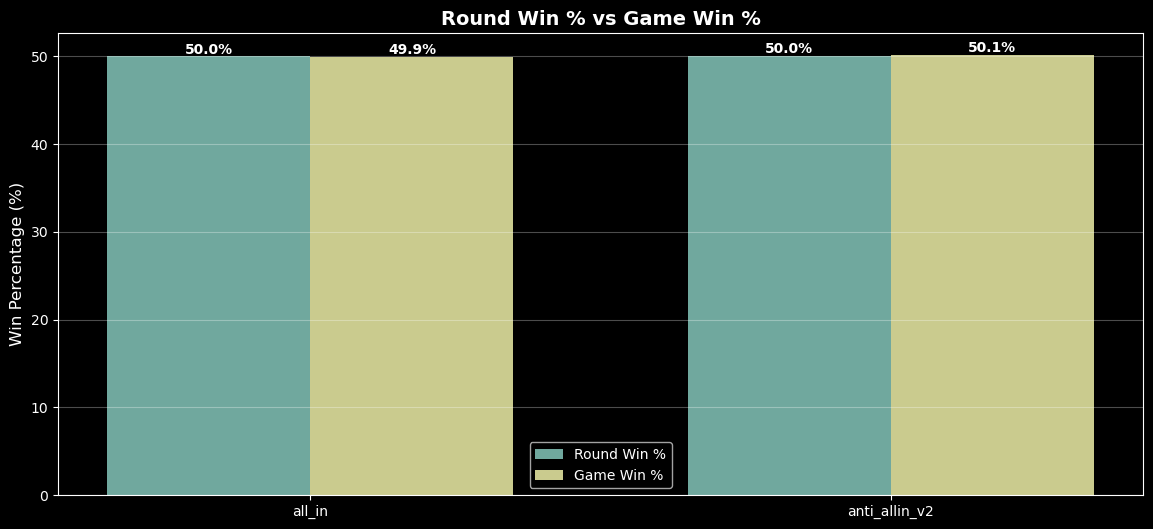

In [12]:
# Calculate round win percentages and game win percentages for both teams

# Round-level statistics
total_rounds = len(df_filtered)
t1_rounds_won = df_filtered['is_t1_winner'].sum()
t2_rounds_won = total_rounds - t1_rounds_won

t1_round_win_pct = (t1_rounds_won / total_rounds) * 100
t2_round_win_pct = (t2_rounds_won / total_rounds) * 100

# Game-level statistics
t1_games_won = len(t1_overall_win)
t2_games_won = len(t2_overall_win)

t1_game_win_pct = (t1_games_won / total_games) * 100
t2_game_win_pct = (t2_games_won / total_games) * 100

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Team': [t1_label, t2_label],
    'Round Win %': [t1_round_win_pct, t2_round_win_pct],
    'Round Wins': [t1_rounds_won, t2_rounds_won],
    'Game Win %': [t1_game_win_pct, t2_game_win_pct],
    'Game Wins': [t1_games_won, t2_games_won],
    'Difference (Round - Game %)': [t1_round_win_pct - t1_game_win_pct, 
                                     t2_round_win_pct - t2_game_win_pct]
})

print("=" * 80)
print("ROUND WIN VS GAME WIN COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\n" + "=" * 80)

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Bar chart comparing percentages
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Round Win %'], width, label='Round Win %', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Game Win %'], width, label='Game Win %', alpha=0.8)

ax.set_ylabel('Win Percentage (%)', fontsize=12)
ax.set_title('Round Win % vs Game Win %', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Team'])
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:# Calculate expenditure and FTE equipment when winning a round for both teams

    # For T1: rounds where T1 won
    t1_win_rounds = df_filtered[df_filtered['is_t1_winner'] == True].copy()
    t1_spent_on_win = t1_win_rounds['t1_spent']
    t1_ratio_on_win = t1_win_rounds['t1_spent'] / (t1_win_rounds['t1_spent'] + t1_win_rounds['t2_spent'])
    t1_fte_on_win = t1_win_rounds['t1_fte_eq']
    t1_fte_ratio_on_win = t1_win_rounds['t1_fte_eq'] / (t1_win_rounds['t1_fte_eq'] + t1_win_rounds['t2_fte_eq'])

    # For T2: rounds where T2 won
    t2_win_rounds = df_filtered[df_filtered['is_t1_winner'] == False].copy()
    t2_spent_on_win = t2_win_rounds['t2_spent']
    t2_ratio_on_win = t2_win_rounds['t2_spent'] / (t2_win_rounds['t1_spent'] + t2_win_rounds['t2_spent'])
    t2_fte_on_win = t2_win_rounds['t2_fte_eq']
    t2_fte_ratio_on_win = t2_win_rounds['t2_fte_eq'] / (t2_win_rounds['t1_fte_eq'] + t2_win_rounds['t2_fte_eq'])



### Spenditure on win

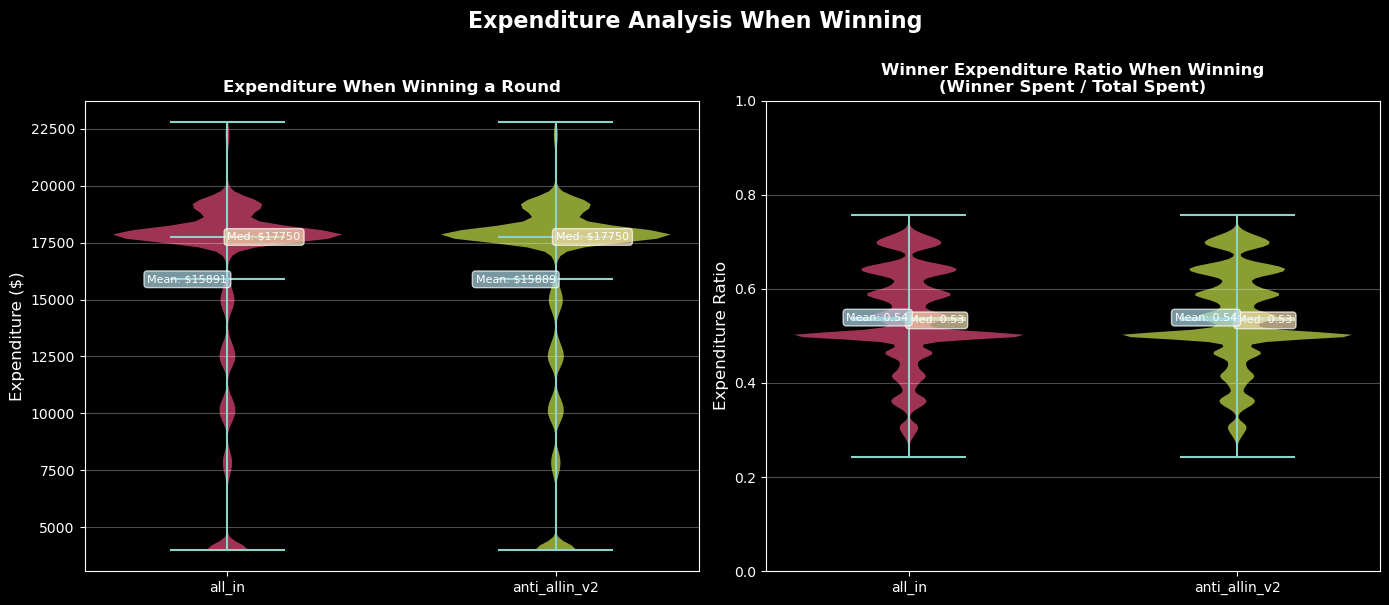

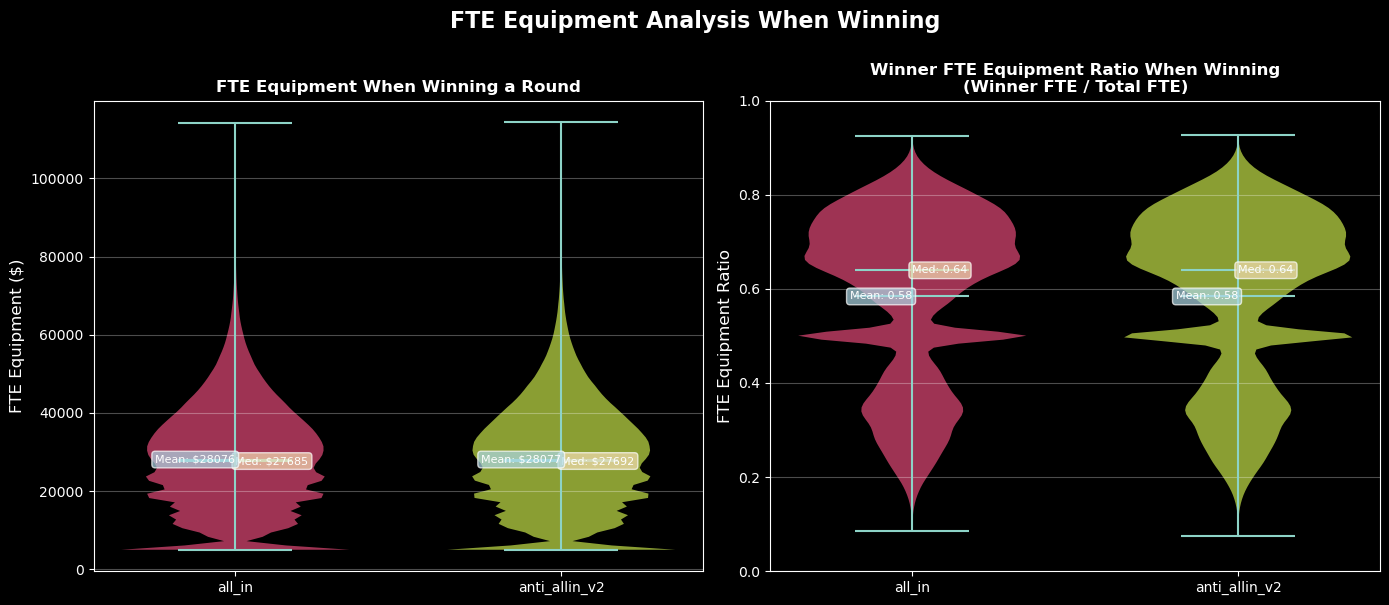

In [13]:
# Calculate expenditure and FTE equipment when winning a round for both teams

# For T1: rounds where T1 won
t1_win_rounds = df_filtered[df_filtered['is_t1_winner'] == True].copy()
t1_spent_on_win = t1_win_rounds['t1_spent']
t1_ratio_on_win = t1_win_rounds['t1_spent'] / (t1_win_rounds['t1_spent'] + t1_win_rounds['t2_spent'])
t1_fte_on_win = t1_win_rounds['t1_fte_eq']
t1_fte_ratio_on_win = t1_win_rounds['t1_fte_eq'] / (t1_win_rounds['t1_fte_eq'] + t1_win_rounds['t2_fte_eq'])

# For T2: rounds where T2 won
t2_win_rounds = df_filtered[df_filtered['is_t1_winner'] == False].copy()
t2_spent_on_win = t2_win_rounds['t2_spent']
t2_ratio_on_win = t2_win_rounds['t2_spent'] / (t2_win_rounds['t1_spent'] + t2_win_rounds['t2_spent'])
t2_fte_on_win = t2_win_rounds['t2_fte_eq']
t2_fte_ratio_on_win = t2_win_rounds['t2_fte_eq'] / (t2_win_rounds['t1_fte_eq'] + t2_win_rounds['t2_fte_eq'])

# ============================================================================
# FIGURE 1: EXPENDITURE WHEN WINNING - VIOLIN PLOTS
# ============================================================================

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for violin plots
spent_data = pd.DataFrame({
    'Expenditure': pd.concat([t1_spent_on_win, t2_spent_on_win]),
    'Team': [t1_label]*len(t1_spent_on_win) + [t2_label]*len(t2_spent_on_win)
})

ratio_data = pd.DataFrame({
    'Ratio': pd.concat([t1_ratio_on_win, t2_ratio_on_win]),
    'Team': [t1_label]*len(t1_ratio_on_win) + [t2_label]*len(t2_ratio_on_win)
})

# Left plot: Expenditure amounts
parts1 = ax1.violinplot([t1_spent_on_win, t2_spent_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
colors = ["#E24A77","#C6E24A",'#4A90E2', '#50C878']
for i, pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax1.set_xticks([0, 1])
ax1.set_xticklabels([t1_label, t2_label])
ax1.set_ylabel('Expenditure ($)', fontsize=12)
ax1.set_title('Expenditure When Winning a Round', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_spent_on_win, t2_spent_on_win]):
    median = data.median()
    mean = data.mean()
    ax1.text(i, median, f'Med: ${median:.0f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax1.text(i, mean, f'Mean: ${mean:.0f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Right plot: Expenditure ratios
parts2 = ax2.violinplot([t1_ratio_on_win, t2_ratio_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
for i, pc in enumerate(parts2['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax2.set_xticks([0, 1])
ax2.set_xticklabels([t1_label, t2_label])
ax2.set_ylabel('Expenditure Ratio', fontsize=12)
ax2.set_title('Winner Expenditure Ratio When Winning\n(Winner Spent / Total Spent)', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_ratio_on_win, t2_ratio_on_win]):
    median = data.median()
    mean = data.mean()
    ax2.text(i, median, f'Med: {median:.2f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax2.text(i, mean, f'Mean: {mean:.2f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig1.suptitle('Expenditure Analysis When Winning', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================================
# FIGURE 2: FTE EQUIPMENT WHEN WINNING - VIOLIN PLOTS
# ============================================================================

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: FTE Equipment amounts
parts3 = ax3.violinplot([t1_fte_on_win, t2_fte_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
for i, pc in enumerate(parts3['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax3.set_xticks([0, 1])
ax3.set_xticklabels([t1_label, t2_label])
ax3.set_ylabel('FTE Equipment ($)', fontsize=12)
ax3.set_title('FTE Equipment When Winning a Round', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_fte_on_win, t2_fte_on_win]):
    median = data.median()
    mean = data.mean()
    ax3.text(i, median, f'Med: ${median:.0f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax3.text(i, mean, f'Mean: ${mean:.0f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Right plot: FTE Equipment ratios
parts4 = ax4.violinplot([t1_fte_ratio_on_win, t2_fte_ratio_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
for i, pc in enumerate(parts4['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax4.set_xticks([0, 1])
ax4.set_xticklabels([t1_label, t2_label])
ax4.set_ylabel('FTE Equipment Ratio', fontsize=12)
ax4.set_title('Winner FTE Equipment Ratio When Winning\n(Winner FTE / Total FTE)', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_fte_ratio_on_win, t2_fte_ratio_on_win]):
    median = data.median()
    mean = data.mean()
    ax4.text(i, median, f'Med: {median:.2f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax4.text(i, mean, f'Mean: {mean:.2f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig2.suptitle('FTE Equipment Analysis When Winning', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


## Create stats on streaks and reversals

max streak length can be calculated as follows: look where the winner has a consecutivewin_start = 0 -> reversal round
Wald-Wolfowitz runs test could be applied here or the KS test to compare distributions
Another method: pandas.series.autocorr

In [15]:
halftime = sim_summary['simulation_config']['game_rules']['halfLength']

# T1 streaks ending due to loss after win streak or at halftime or game end
t1_streaks_end = df_filtered[
    ((df_filtered['t1_consecutive_losses_start'] == 0) & 
    (df_filtered['t1_consecutive_losses'] == 1) & df_filtered['t1_consecutive_wins_start'] > 0) | 
    ((df_filtered['round_number'] == halftime) &
    (df_filtered['t1_consecutive_wins'] > 0))
]

winner_last_round_data = df_filtered.merge(
    game_scores[['round_number']],  # Select the round_number column from game_scores
    on=['game_id', 'round_number'],
    how='inner'
)

t1_streaks_end = pd.concat([t1_streaks_end, winner_last_round_data[winner_last_round_data['is_t1_winner'] == True]]).drop_duplicates(keep=False)

# T2 streaks ending due to loss after win streak or at halftime or game end
t2_streaks_end = df_filtered[
    ((df_filtered['t2_consecutive_losses_start'] == 0) & 
    (df_filtered['t2_consecutive_losses'] == 1) & (df_filtered['t2_consecutive_wins_start'] > 0)) | 
    ((df_filtered['round_number'] == halftime) &
    (df_filtered['t2_consecutive_wins'] > 0))
]

t2_streaks_end = pd.concat([t2_streaks_end, winner_last_round_data[winner_last_round_data['is_t1_winner'] == False]]).drop_duplicates(keep=False)

# Randomly sample a game_id from game_scores index
random_game_id = game_scores.sample(1).index[0]
# print(f"\nSample Game ID for streak verification: {random_game_id}")

# print(t1_streaks_end[t1_streaks_end['game_id'] == random_game_id])
# print(t2_streaks_end[t2_streaks_end['game_id'] == random_game_id])




In [16]:
# Merging Streak data to form one dataframe of the reversals, halftime and game end

# Add is_t1_streak column to identify which team's streak ended
t1_streaks_end['is_t1_streak'] = True
t2_streaks_end['is_t1_streak'] = False

# Combine both streak dataframes
game_reversals = pd.concat([t1_streaks_end, t2_streaks_end])

# Sort by game_id and round_number for better readability
game_reversals = game_reversals.sort_values(['game_id', 'round_number']).reset_index(drop=True)

# print(game_reversals[game_reversals['game_id'] == random_game_id])

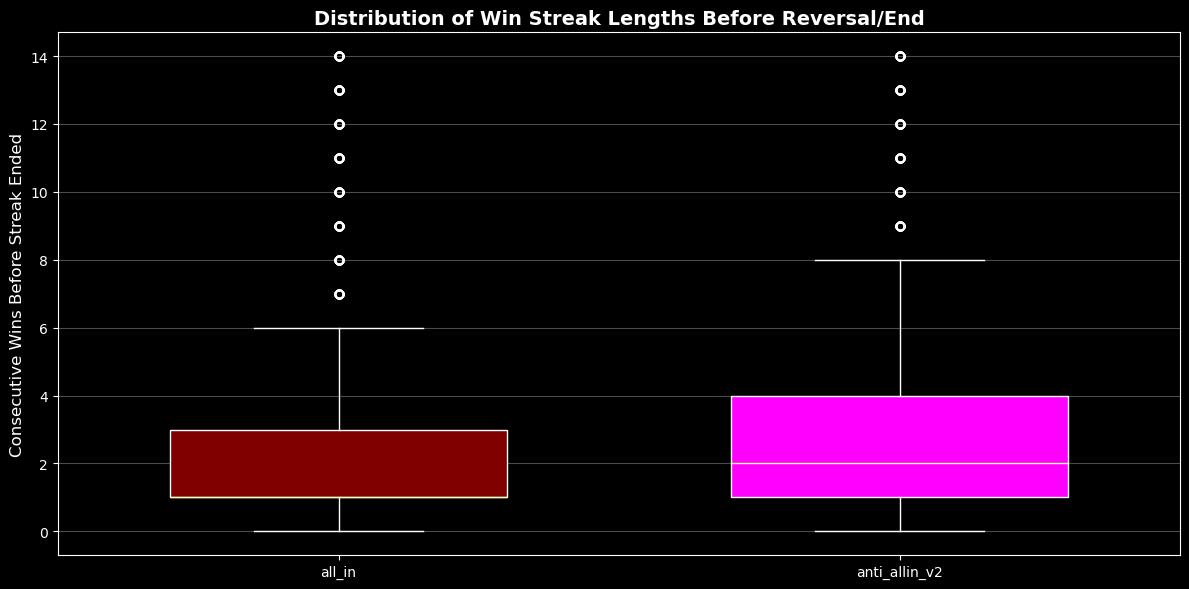

In [17]:
# Create boxplot for T1 win streaks that ended
fig, ax = plt.subplots(figsize=(12, 6))

# Create side-by-side boxplots
bp = ax.boxplot([t1_streaks_end['t1_consecutive_wins_start'], t2_streaks_end['t2_consecutive_wins_start']], 
    tick_labels=[t1_label, t2_label],
    patch_artist=True,
    widths=0.6)

# Color the boxes
colors = ['maroon', 'fuchsia']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)


ax.set_ylabel('Consecutive Wins Before Streak Ended', fontsize=12)
ax.set_title('Distribution of Win Streak Lengths Before Reversal/End', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



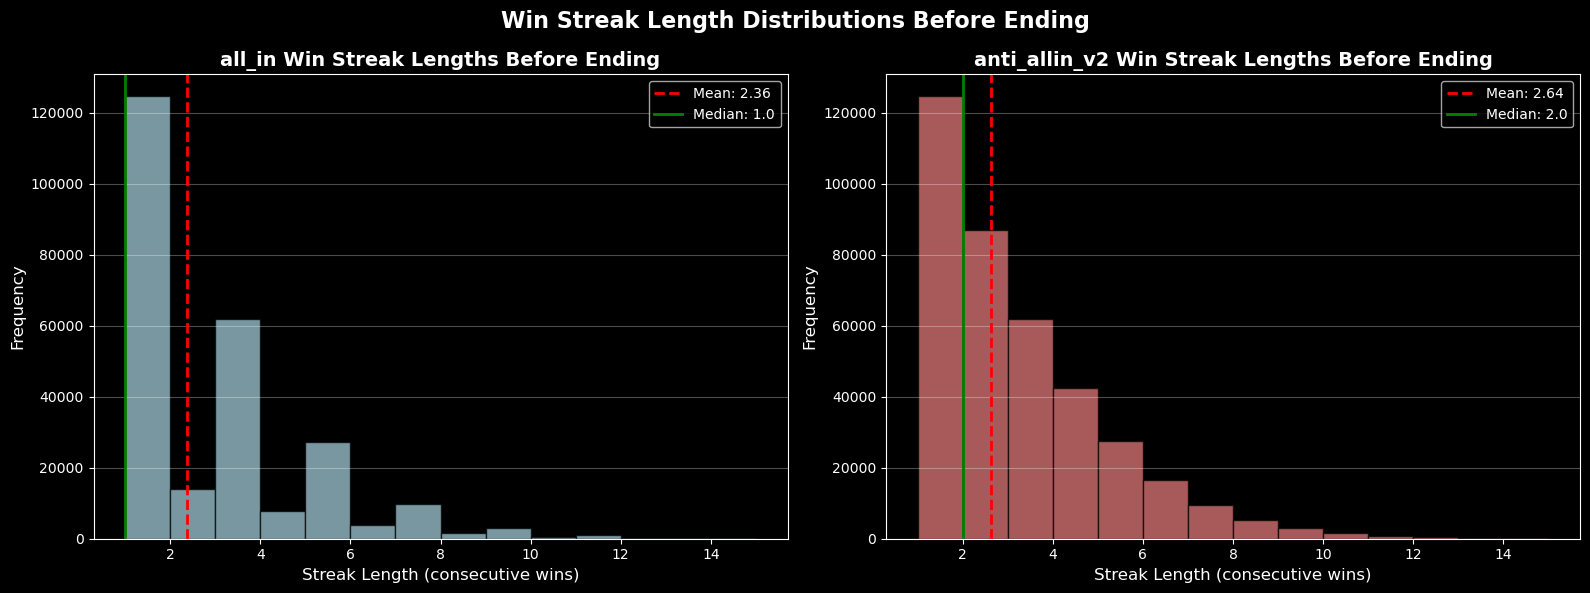


all_in streaks: Count=278549, Mean=2.36, Median=1.0, Std=2.08
anti_allin_v2 streaks: Count=404557, Mean=2.64, Median=2.0, Std=2.03


In [18]:
# Extract streak lengths from the dataframes
t1_streaks_ends = t1_streaks_end[t1_streaks_end['is_t1_streak'] == True]['t1_consecutive_wins_start'].values
t2_streaks_ends = t2_streaks_end[t2_streaks_end['is_t1_streak'] == False]['t2_consecutive_wins_start'].values

# Create histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# T1 histogram
axes[0].hist(t1_streaks_ends, bins=range(1, int(max(t1_streaks_ends))+2), 
             alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_xlabel('Streak Length (consecutive wins)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'{t1_label} Win Streak Lengths Before Ending', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add statistics text
t1_mean = t1_streaks_ends.mean()
t1_median = np.median(t1_streaks_ends)
axes[0].axvline(t1_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_mean:.2f}')
axes[0].axvline(t1_median, color='green', linestyle='-', linewidth=2, label=f'Median: {t1_median:.1f}')
axes[0].legend()

# T2 histogram
axes[1].hist(t2_streaks_ends, bins=range(1, int(max(t2_streaks_ends))+2), 
             alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Streak Length (consecutive wins)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'{t2_label} Win Streak Lengths Before Ending', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add statistics text
t2_mean = t2_streaks_ends.mean()
t2_median = np.median(t2_streaks_ends)
axes[1].axvline(t2_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_mean:.2f}')
axes[1].axvline(t2_median, color='green', linestyle='-', linewidth=2, label=f'Median: {t2_median:.1f}')
axes[1].legend()

fig.suptitle('Win Streak Length Distributions Before Ending', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{t1_label} streaks: Count={len(t1_streaks_ends)}, Mean={t1_mean:.2f}, Median={t1_median:.1f}, Std={t1_streaks_ends.std():.2f}")
print(f"{t2_label} streaks: Count={len(t2_streaks_ends)}, Mean={t2_mean:.2f}, Median={t2_median:.1f}, Std={t2_streaks_ends.std():.2f}")

In [ ]:
# Exporting all output to HTML report

from datetime import datetime
import os

# Skip HTML export if running in batch mode (batch script handles export)
if 'MATCHUP_FOLDER' not in os.environ:
    t1_strat = sim_summary['simulation_config']['team1_strategy']
    t2_strat = sim_summary['simulation_config']['team2_strategy']

    # Generate timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"{FOLDER_PATH}\\analysis_report_{timestamp}_{t1_strat}_vs_{t2_strat}.html"

    # Export notebook to HTML without code cells
    os.system(f'jupyter nbconvert --to html --no-input "{os.path.abspath("analysis_notebook_v2.ipynb")}" --output "{output_filename}"')
    print(f"✓ HTML report saved: {output_filename}")
else:
    print("ℹ️  Batch mode: HTML export handled by batch script")


0